## <span style='color:teal'>Learning to Steer for Self-Driving Cars</span> <span style='color:orange'>with <span style='color:green'>Attention visualization</span> (SqueezeNet Model)

####  Importing required Packages

In [1]:
import cv2
import random
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, concatenate, Input
from keras.regularizers import l2

from tqdm import tqdm

import scipy.misc
from subprocess import call

Using TensorFlow backend.


### The Dataset

#### 1. Retrieve path of images & Labels

In [2]:
import glob
from natsort import natsorted

img_paths=natsorted(glob.glob('driving_dataset/*.jpg'))
steers=np.loadtxt('driving_dataset/data.txt',usecols=(1,))

#### 2. Sample Image & it's Steering angle

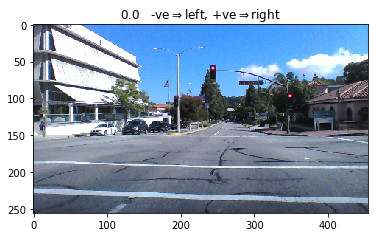

In [3]:
random_int=random.randint(0,10000)
image_path = 'driving_dataset/'+str(random_int)+'.jpg'
img = plt.imread(image_path)
plt.imshow(img)
plt.title(str(steers[random_int])+'   -ve$\Rightarrow$left, +ve$\Rightarrow$right')
plt.show()

### Preprocessing the image data

#### 1. JPG to HSV

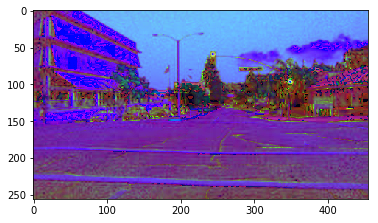

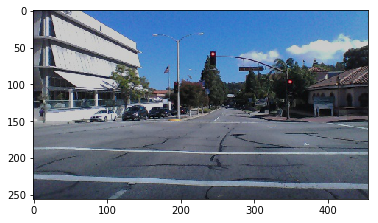

In [4]:
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(hsv)
plt.show()

def change_bright(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = random.uniform(0.6,1)*hsv[:,:,2]
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return new_img

plt.imshow(change_bright(img))
plt.show()

#### 2. Cropping Upper part of the image (Sky region mainly) & Resizing

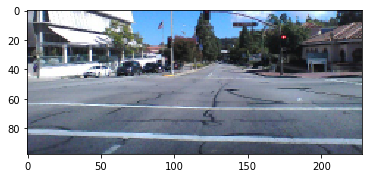

In [5]:
def crop_sky(img):
    cropped_img = cv2.resize(img[60::, ::], (0,0), fx=0.5, fy=0.5)
    return cropped_img

plt.imshow(crop_sky(img))
plt.show()

#### 3. Sample Data (after_Preprocessing)

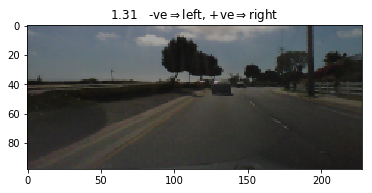

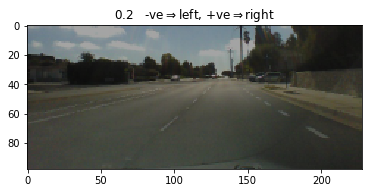

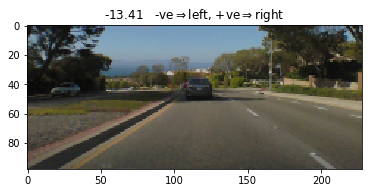

In [6]:
for i in range(3):
    random_int = random.randint(0,10000)
    img = plt.imread(img_paths[random_int])
    new = crop_sky(change_bright(img))
    plt.imshow(new)
    plt.title(str(steers[random_int])+'   -ve$\Rightarrow$left, +ve$\Rightarrow$right')
    plt.show()

### CV Partition

#### 1. Train-Test split

In [7]:
img_paths, img_valid, steers, steers_valid = train_test_split(img_paths, steers, test_size = 0.10, random_state = 100)

print('Training instances:',len(steers))
print('Validation instances',len(steers_valid))

Training instances: 40865
Validation instances 4541


#### 2. Generating Training and Validation Batches

In [8]:
def gen_batch(batch_size,Image_path, Steering_Angle):
    batch_x=np.zeros((batch_size,98, 228, 3))
    batch_y=np.zeros((batch_size,1))
    pointer=0
    (img_set, steers_set)=shuffle(Image_path, Steering_Angle)
    while True:
        for i in range(batch_size):
            img=plt.imread(img_set[pointer])
            steer=steers_set[pointer]
            new_img=crop_sky(change_bright(img))
            
            batch_x[i]=new_img
            batch_y[i]=steer
            pointer+=1
            if pointer==len(img_set)-1: pointer=0
        
        yield batch_x, batch_y

In [9]:
generator=gen_batch(32,img_paths,steers)
val_gen=gen_batch(32,img_valid, steers_valid)

## <span style="color:teal">SqueezeNet Model </span>

#### Fire Module

In [10]:
def fire(x, squeeze=16, expand=64):
    x = Conv2D(squeeze, (1,1), activation='relu')(x)

    left = Conv2D(expand, (1,1), activation='relu')(x)

    right = Conv2D(expand, (3,3), padding='same',activation='relu')(x)

    x = concatenate([left, right], axis=3)
    return x

#### Architecture

In [11]:
input_shape = (98, 228, 3)
img_input=Input(shape=input_shape)

x = Conv2D(64, (3, 3), strides=(2, 2), activation='relu')(img_input)

x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=16, expand=16)
x = fire(x, squeeze=16, expand=16)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=32, expand=32)
x = fire(x, squeeze=32, expand=32)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

x = fire(x, squeeze=48, expand=48)
x = fire(x, squeeze=48, expand=48)
x = fire(x, squeeze=64, expand=64)
x = fire(x, squeeze=64, expand=64)
x = Dropout(0.5)(x)

x = Conv2D(5, (1, 1), activation='relu')(x)

x = Flatten()(x)

out = Dense(1, activation='linear',name='prediction')(x)


modelsqueeze= Model(img_input, out)

modelsqueeze.compile(optimizer='adam', loss='mse')
modelsqueeze.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 98, 228, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 113, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 23, 56, 64)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 23, 56, 16)   1040        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_3 (

#### * Compling & Saving the weights of the model

In [12]:
history_Squeeze= modelsqueeze.fit_generator(generator, steps_per_epoch = int(len(img_paths)/4-10), epochs=25, 
                                    validation_data=val_gen, validation_steps = 50)

In [13]:
modelsqueeze.save_weights('model_squeeze.h5',overwrite=True)

#### * Plot of Training & Validation Losses

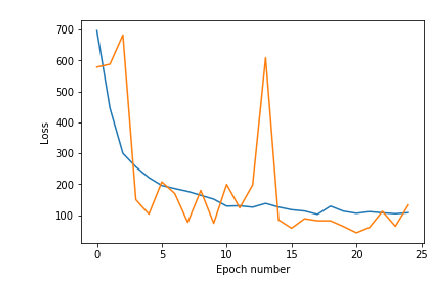

In [14]:
plt.figure(figsize=(12,5))
plt.plot(history_Squeeze.history['loss'])
plt.plot(history_Squeeze.history['val_loss'])
plt.xlabel('Epoch number'), plt.ylabel('Loss')
plt.savefig('lossSqueeze.png',dpi=200)
plt.imshow(plt.imread('lossSqueeze.png')), plt.axis('off')
plt.show()

#### * Load weights from the model.

In [15]:
modelsqueeze.load_weights('model_squeeze.h5')

## <span style='color:blue'> Visualization </span>

#### Architecture

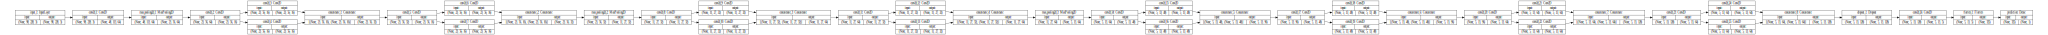

In [16]:
from IPython import display
from keras.utils.vis_utils import model_to_dot

display.SVG(model_to_dot(modelsqueeze, show_shapes=True, rankdir='LR').create(prog='dot', format='svg'))

#### Steering wheel

In [17]:
from vis.visualization import visualize_cam, overlay
from vis.utils import utils

smooth_ang = 0
img = cv2.resize(cv2.imread('steering_wheel_image.jpg'),(256,256))

rows,cols,_ = img.shape
img.shape

(256, 256, 3)

In [18]:
upto=1000

for_plot=np.zeros((upto,256, 1166, 3),dtype='uint8')


for i in tqdm(range(upto)):

    full_image = plt.imread("driving_dataset/" + str(i) + ".jpg")
    
    preprocessed_img=crop_sky(change_bright(full_image))
    #---------------------------------------------------------------------------------------------------------------
    
    ang = modelsqueeze.predict(np.array([preprocessed_img]))
    
    smooth_ang += 0.1 * pow(abs((ang-smooth_ang)), 2/3) * (ang-smooth_ang) / abs(ang-smooth_ang)

    show_ang = cv2.warpAffine(img,cv2.getRotationMatrix2D((cols/2,rows/2),-smooth_ang,1),(cols,rows))
    #---------------------------------------------------------------------------------------------------------------
    
    heatmap = visualize_cam(modelsqueeze, layer_idx=-1, filter_indices=0, 
                        seed_input=preprocessed_img, grad_modifier='small_values')
    
    vis_img = cv2.resize(overlay(preprocessed_img, heatmap, alpha=0.7),(455,256))
    #---------------------------------------------------------------------------------------------------------------
    
    for_plot[i] = np.concatenate((full_image,show_ang,vis_img),axis=1)


100%|██████████| 1000/1000 [13:38<00:00,  1.22it/s]


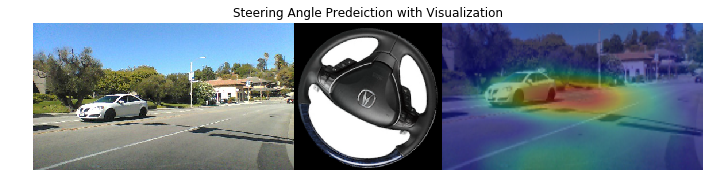

In [19]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(12,5))

ims = []

for image in for_plot:
    plt.title('Steering Angle Predeiction with Visualization')
    plt.axis('off')
    im = plt.imshow(image,animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

ani.save('dynamic_images.mp4')

## <span style='color:teal'>Learing to Steer in Action</span>
<video width="1000" controls src="dynamic_images.mp4" />

In [20]:
# Reference1: End-to-End Learning to Steer for Self-Driving Cars with Small and Eﬃcient Networks- Norman Di Palo
# Reference2: End to End Learning for Self-Driving Cars- Bojarski et al
# Bhartendu, Machine Learning & Computing